# Chose 3 different classification techniques

## Read data
Only `learn` file relevant for training:
`data/breast_cancer/breast-cancer-diagnostic.shuf.lrn.csv`
Only `test` file relevant for testing:
`data/breast_cancer/breast-cancer-diagnostic.shuf.test.csv`

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
breast_cancer = pd.read_csv('data/breast_cancer/breast-cancer-diagnostic.shuf.lrn.csv')
breast_cancer_full_test = pd.read_csv('data/breast_cancer/breast-cancer-diagnostic.shuf.tes.csv')

### Check data
`info()` method shows if there are missing values
it shows that there aren't any missing values (non-null for every feature)

In [3]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 32 columns):
ID                         285 non-null int64
class                      285 non-null object
radiusMean                 285 non-null float64
 textureMean               285 non-null float64
 perimeterMean             285 non-null float64
 areaMean                  285 non-null float64
 smoothnessMean            285 non-null float64
 compactnessMean           285 non-null float64
 concavityMean             285 non-null float64
 concavePointsMean         285 non-null float64
 symmetryMean              285 non-null float64
 fractalDimensionMean      285 non-null float64
 radiusStdErr              285 non-null float64
 textureStdErr             285 non-null float64
 perimeterStdErr           285 non-null float64
 areaStdErr                285 non-null float64
 smoothnessStdErr          285 non-null float64
 compactnessStdErr         285 non-null float64
 concavityStdErr           285 non

In [4]:
print(breast_cancer['class'].unique())


['B' 'M']


(array([189.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  96.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

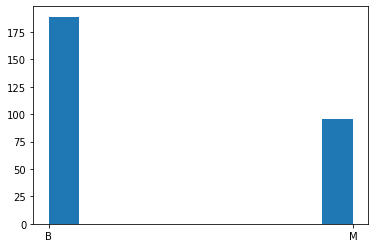

In [5]:
plt.hist(breast_cancer['class'])

## Correlation map

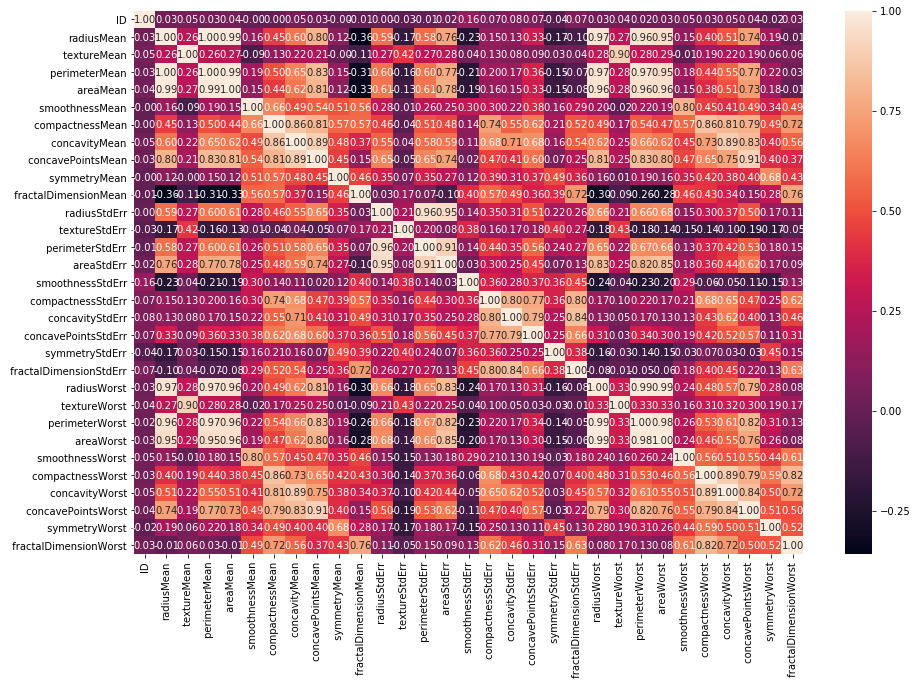

In [6]:
plt.figure(figsize=(15,10))
sns.heatmap(breast_cancer.corr(),annot=True,fmt='.2f')
plt.show()

## Creating train and test data 
Using a stratified approach to ensure all the classes are in the training data.

In [7]:
X_base = breast_cancer.drop(['ID','class'], axis = 1).values
y_base = breast_cancer['class'].values
X_full_test = breast_cancer_full_test.drop(['ID'], axis=1).values

In [8]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [9]:
rus = RandomUnderSampler(random_state = 42)
ros = RandomOverSampler(random_state = 42)
X_under, y_under = rus.fit_sample(X_base, y_base)
X_over, y_over = ros.fit_sample(X_base, y_base)

In [10]:
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, test_size = 0.3, random_state = 42, stratify=y_base)
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under, y_under, test_size = 0.3, random_state = 42, stratify=y_under)
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 42, stratify=y_over)

In [11]:
X_train, X_test, y_train, y_test = X_base_train, X_base_test, y_base_train, y_base_test
#X_train, X_test, y_train, y_test = X_under_train, X_under_test, y_under_train, y_under_test
#X_train, X_test, y_train, y_test = X_over_train, X_over_test, y_over_train, y_over_test

X, y = X_base, y_base
#X, y = X_under, y_under
#X, y = X_over, y_over

In [12]:
from sklearn.pipeline import Pipeline

# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [48]:
import math
def plot_parameter_analysis(grid, params, param1, param2, params_base, method_name, function_name="accuracy", dataset_name="breast_cancer"):
    scores_df = pd.DataFrame(grid.cv_results_)
    
    #print('params:', params.keys())
    grid_shape = [len(params[param]) for param in params.keys()] 
    scores_mean = [x for x in scores_df['mean_test_score']]
    scores_mean = np.array(scores_mean).reshape(grid_shape)
    scores_std = [x for x in scores_df['std_test_score']]
    scores_std = np.array(scores_std).reshape(grid_shape)
    
    #print('param1', param1)
    #print('param2', param2)
    print('init', scores_mean.shape)#, scores_mean)
    for ind, param in enumerate(params.keys()):
        if param is not param1 and param is not param2:
            #print('param', ind,':', param)
            #print('before', scores_mean.shape)#, scores_mean)
            delete_arr = np.array(range(len(params[param])))
            #print ('delete_array', delete_arr)
            delete_arr = delete_arr[[((params[param][p] is not params_base[param][0]) 
                                      if not isinstance(params_base[param][0], float) 
                                         and not isinstance(params[param][p], float)
                                      else math.isclose(params[param][p], params_base[param][0]))
                                     for p in range(len(params[param]))]]
        
            #print ('delete_array', delete_arr)
            scores_mean = np.delete(scores_mean, delete_arr, axis=ind)
            scores_std = np.delete(scores_std, delete_arr, axis=ind)
            #print('after', scores_mean.shape)#, scores_mean)
    scores_mean = np.squeeze(scores_mean)
    scores_std = np.squeeze(scores_std)
    #print('final score shape', scores_mean.shape, scores_mean)
    
    plt.figure(figsize=(20, 20))
    for ind, i in enumerate(params[param2]):
        if list(params.keys()).index(param1) < list(params.keys()).index(param2):
            plt.plot(params[param1], scores_mean[:,ind], label=param2+': ' + str(i))
            plt.plot(params[param1], scores_mean[:,ind] + scores_std[:,ind], color='black', alpha=0.3)
            plt.plot(params[param1], scores_mean[:,ind] - scores_std[:,ind], color='black', alpha=0.3)
        else:
            plt.plot(params[param1], scores_mean[ind], label=param2+': ' + str(i))
            plt.plot(params[param1], scores_mean[ind] + scores_std[ind], color='black', alpha=0.3)
            plt.plot(params[param1], scores_mean[ind] - scores_std[ind], color='black', alpha=0.3)
    plt.legend()
    plt.xlabel(param1)
    plt.ylabel('Mean score (' + function_name + ')')
    plt.title('Parameter analysis for ' + method_name + "\n" + dataset_name)
    plt.show()

## Starting with a simple model to:
+ get a sense of how challenging the problem is
+ many more things might go wrong with complex models
+ how much signal can we pull out using basic models

## Logistic Regression
__Score history:__  

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 0.34 | 0.17, 0.50, 0.25 | 0.11, 0.34, 0.17 |
| with MinMaxScaler | 0.98 | 0.98, 0.97, 0.97 | 0.98, 0.98, 0.98 |
| with RobustScaler | 1.00 | 1.00, 1.00, 1.00 | 1.00, 1.00, 1.00 |
| - | - | - | - |


### Logistic Regression parameters
TODO

In [85]:
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix  

In [103]:
pipe_logreg = Pipeline([
    #('scaler', MinMaxScaler()),
    ('scaler', RobustScaler()),
    ('logreg', LogisticRegression())
])

In [104]:
# create parameter list for ridge regression
params_logreg = {
    'logreg__C':[0.5, 0.6, 0.7, 1.1],
    'logreg__class_weight': [None, 'balanced']
}

In [105]:
# setup cross validation parameter grid search
grid_logreg = GridSearchCV(estimator=pipe_logreg,
    param_grid=params_logreg,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1)

In [106]:
# fitting model on training data
grid_logreg.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('logreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
        

In [107]:
# extracting best parameters (can be used for finer hyper parameter tuning)
grid_logreg.best_params_

{'logreg__C': 0.5, 'logreg__class_weight': 'balanced'}

In [108]:
grid_logreg.score(X_test, y_test) 


1.0

In [109]:
y_pred = grid_logreg.predict(X_test)

In [110]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           B       1.00      1.00      1.00        57
           M       1.00      1.00      1.00        29

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



In [111]:
print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

[[57  0]
 [ 0 29]]


init (4, 2)


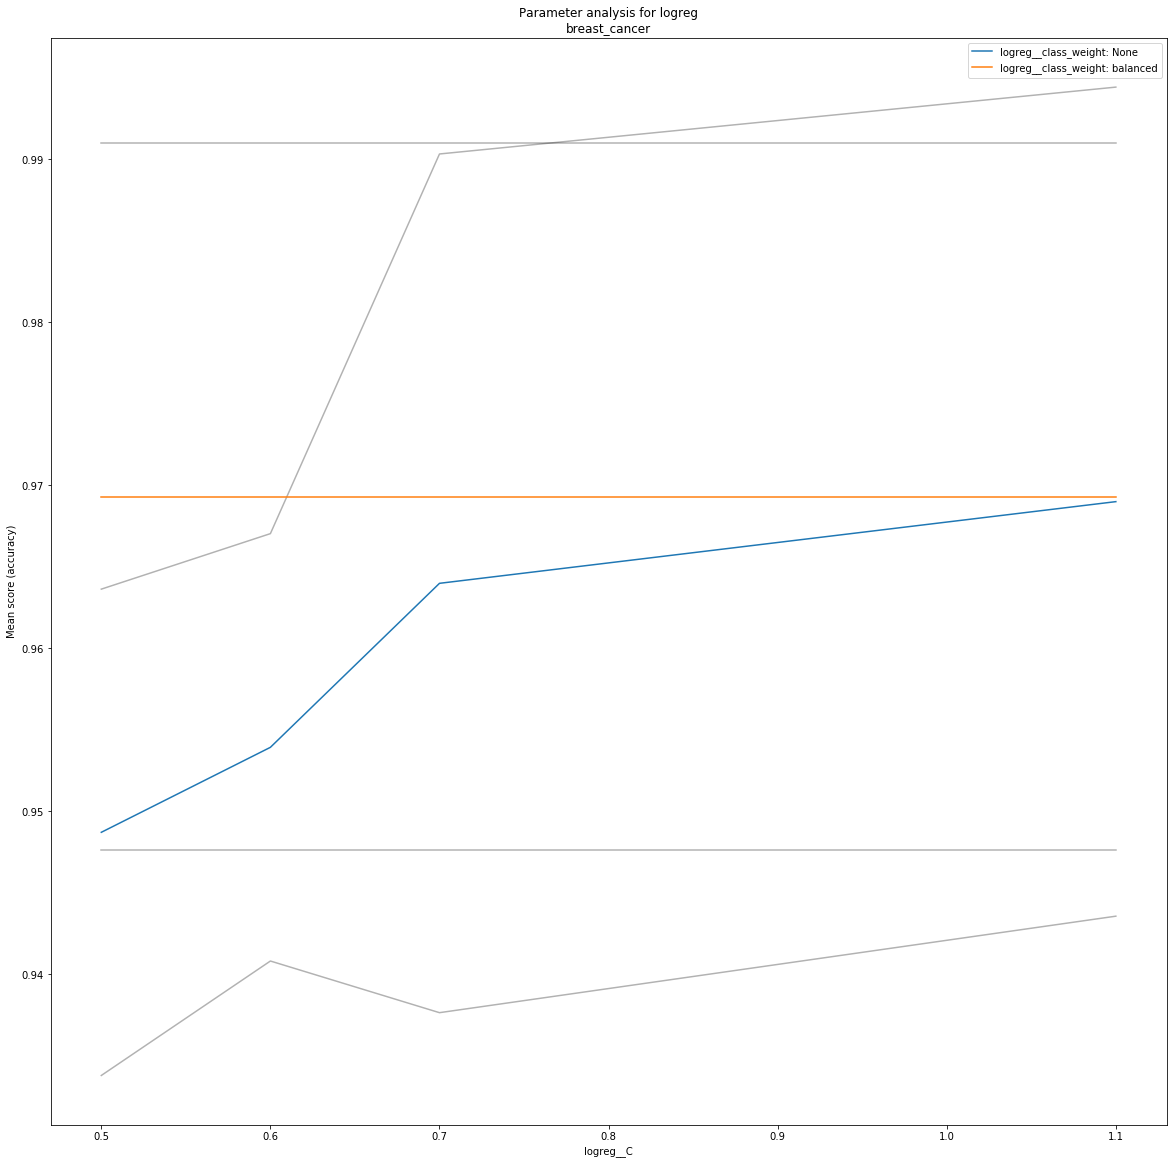

In [49]:
params_logreg_base = {}
plot_parameter_analysis(grid=grid_logreg, params=params_logreg, param1='logreg__C', 
                        param2='logreg__class_weight', params_base=params_logreg_base, 
                        method_name="logreg")

## KNN-Classifier
__Score history:__

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 0.83 | 0.82, 0.78, 0.79 | 0.82, 0.83, 0.82 |
| with MinMaxScaler | 0.98 | 0.98, 0.97, 0.97 | 0.98, 0.98, 0.98 |
| - | - | - | - |

### KNN Parameters:

In [36]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.preprocessing import MinMaxScaler


In [137]:
pipe_knn = Pipeline([
    ('scaler', MinMaxScaler()),
    #('scaler1', RobustScaler()),
    ('knn', KNeighborsClassifier())
])

In [138]:
params_knn = {
    'knn__n_neighbors': [x for x in range(1,50,2)], 
    'knn__p': [1, 2],
    'knn__weights': ['uniform', 'distance']
}


In [139]:
grid_knn = GridSearchCV(estimator=pipe_knn,
    param_grid=params_knn,
    cv=3,
    #scoring='f1_weighted',
    scoring='accuracy',
    verbose=2,
    n_jobs=-1)

In [140]:
grid_knn.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'knn__n_neig

In [141]:
grid_knn.best_params_

{'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'}

In [142]:
grid_knn.score(X_test, y_test) 

0.9767441860465116

In [143]:
y_pred_knn = grid_knn.predict(X_test)

In [144]:
print(classification_report(y_test, y_pred_knn)) 

              precision    recall  f1-score   support

           B       0.97      1.00      0.98        57
           M       1.00      0.93      0.96        29

    accuracy                           0.98        86
   macro avg       0.98      0.97      0.97        86
weighted avg       0.98      0.98      0.98        86



In [145]:
print(confusion_matrix(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn)

[[57  0]
 [ 2 27]]


init (25, 2, 2)


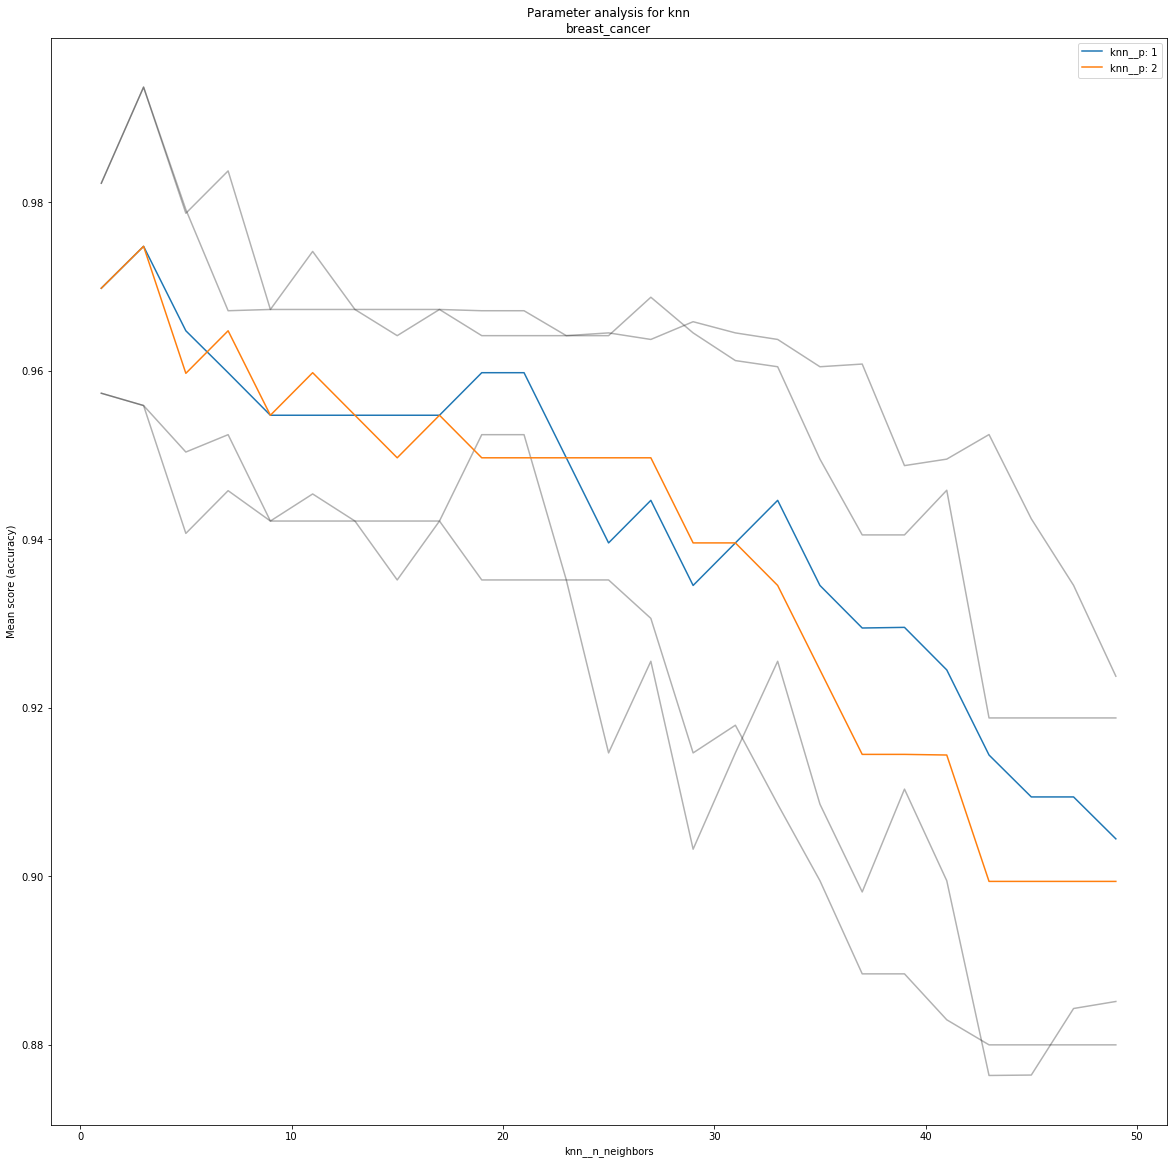

In [146]:
params_knn_base = {
    'knn__weights': ['uniform']
}
plot_parameter_analysis(grid=grid_knn, params=params_knn, param1='knn__n_neighbors', 
                        param2='knn__p', params_base=params_knn_base, 
                        method_name="knn")


### train on full learn dataset and save output

In [55]:
grid_knn.fit(X, y)
y_full_pred_knn = grid_knn.predict(X_full_test)
test_out_knn = pd.DataFrame()
test_out_knn['ID'] = breast_cancer_full_test['ID']
test_out_knn['class'] = y_full_pred_knn
test_out_knn.to_csv('breast_cancer_test_knn.csv', index=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.6s finished


In [56]:
grid_knn.best_estimator_

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=9, p=2,
                                      weights='distance'))],
         verbose=False)

## Random Forest
__Score history:__

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 1.00 | 1.00, 1.00, 1.00 | 1.00, 1.00, 1.00 |
| - | - | - | - |

### Random Forest parameters
- __n_estimators:__
    - number of trees in the forest
- __max_depth:__
    - maximum depth of the tree
- __min_samples_split:__
    - the min. number of samples required to split an internal node
- __min_samples_leaf:__
    - the minimum number of samples required to be at a leaf node
- __min_weight_fraction_leaf:__
    - the minimum weighted fraction of the sum total of weights
- __max_features:__
    - the number of features to consider when looking for the best split
- __min_impurity_decrease:__
    - A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [52]:
pipe_rf = PipelineRFE([
    ('rf', RandomForestClassifier())
])

In [53]:
params_rf = {
    'rf__class_weight': [None, 'balanced'],
    'rf__max_depth': [None, 5, 7, 9, 10, 11, 13, 15, 20],
    'rf__max_leaf_nodes': [None, 5, 6, 7, 8, 9],
    'rf__min_samples_split': [2, 3, 4, 5, 6],
    'rf__n_estimators': [50, 100]
}


In [54]:
grid_rf = GridSearchCV(estimator=pipe_rf,
    param_grid=params_rf,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1)


In [55]:
grid_rf.fit(X_train, y_train)


Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  3.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=PipelineRFE(memory=None,
                                   steps=[('rf',
                                           RandomForestClassifier(bootstrap=True,
                                                                  ccp_alpha=0.0,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  max_samples=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity_split=None,
           

In [56]:
grid_rf.best_params_

{'rf__class_weight': None,
 'rf__max_depth': None,
 'rf__max_leaf_nodes': None,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 50}

In [57]:
grid_rf.score(X_test, y_test)

0.9883720930232558

In [58]:
y_pred_rf = grid_rf.predict(X_test)

In [59]:
print(classification_report(y_test, y_pred_rf)) 

              precision    recall  f1-score   support

           B       0.98      1.00      0.99        57
           M       1.00      0.97      0.98        29

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



In [60]:
print(confusion_matrix(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)

[[57  0]
 [ 1 28]]


init (2, 9, 6, 5, 2)


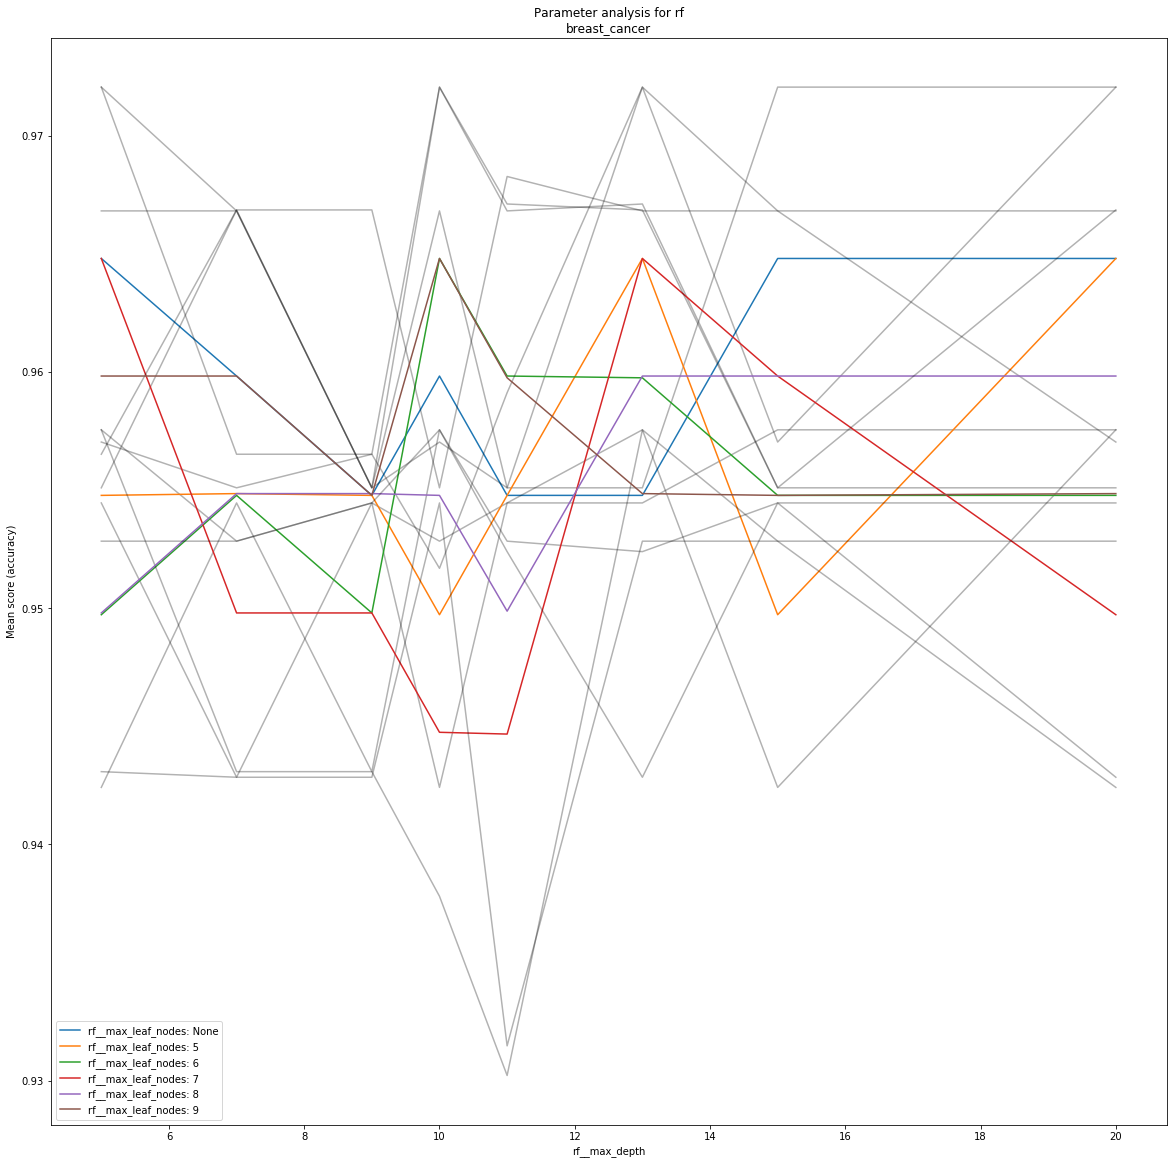

In [61]:
params_rf_base = {
    'rf__class_weight': [None],
    'rf__max_depth': [None, 5, 7, 9, 10, 11, 13, 15, 20],
    'rf__max_leaf_nodes': [None],
    'rf__min_samples_split': [2, 3, 4, 5, 6],
    'rf__n_estimators': [50]
}
plot_parameter_analysis(grid=grid_rf, params=params_rf, param1='rf__max_depth',
                        param2='rf__max_leaf_nodes', params_base=params_rf_base,
                        method_name='rf')

init (2, 9, 6, 5, 2)


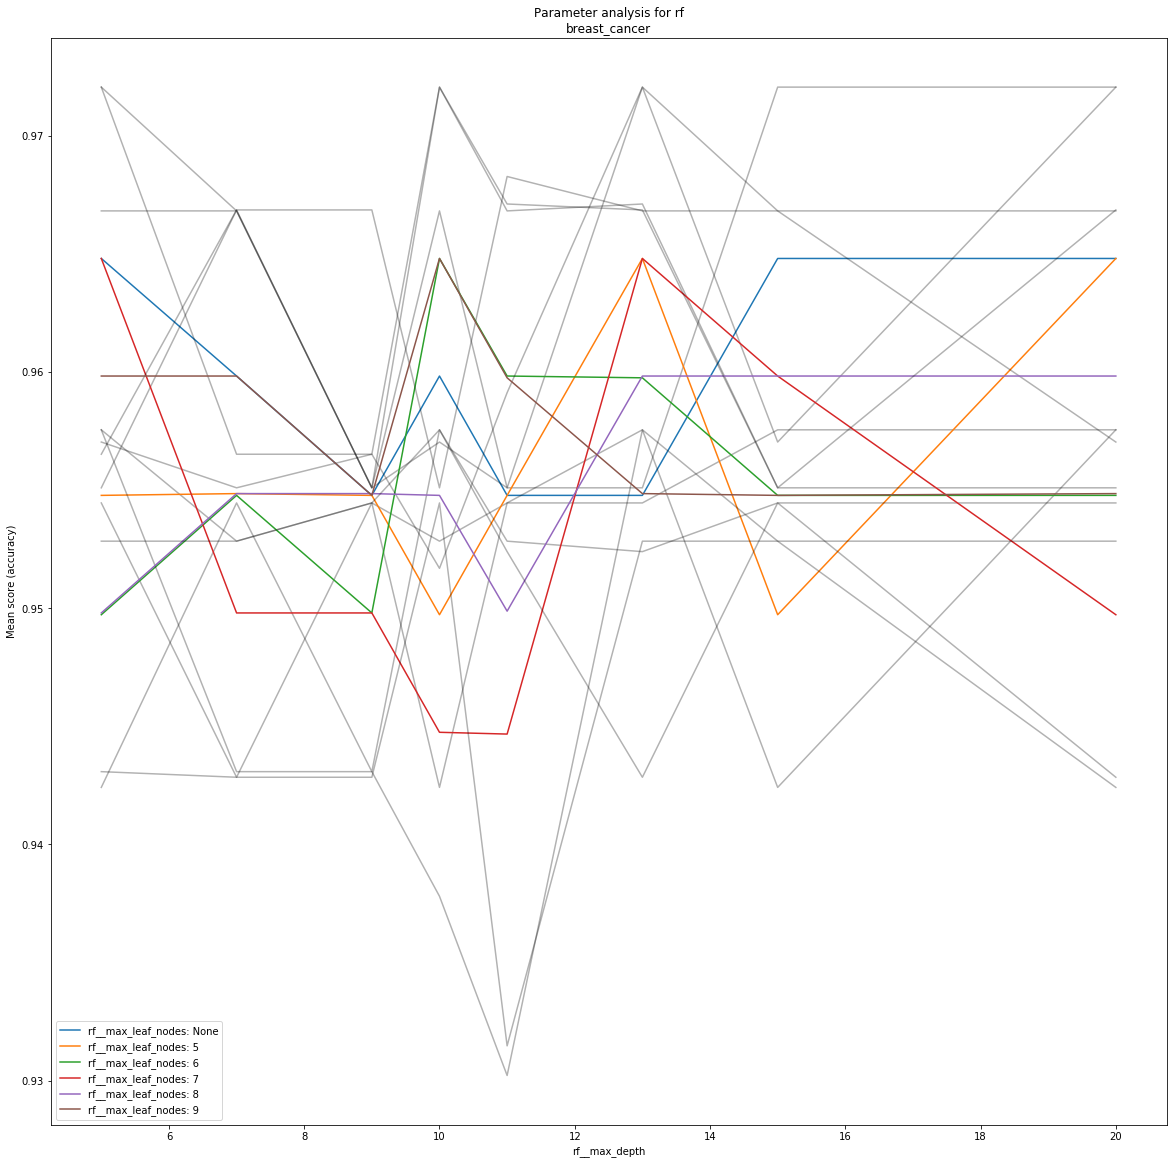

In [62]:
params_rf_base = {
    'rf__class_weight': [None],
    'rf__max_depth': [None, 5, 7, 9, 10, 11, 13, 15, 20],
    'rf__max_leaf_nodes': [None, 5, 6, 7, 8, 9],
    'rf__min_samples_split': [2],
    'rf__n_estimators': [50]
}
plot_parameter_analysis(grid=grid_rf, params=params_rf, param1='rf__max_depth',
                        param2='rf__max_leaf_nodes', params_base=params_rf_base,
                        method_name='rf')

### train on full learn dataset and save output

In [232]:
grid_rf.fit(X, y)
y_full_pred_rf = grid_rf.predict(X_full_test)
test_out_rf = pd.DataFrame()
test_out_rf['ID'] = breast_cancer_full_test['ID']
test_out_rf['class'] = y_full_pred_rf
test_out_rf.to_csv('breast_cancer_test_rf.csv', index=False)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  4.6min finished


In [30]:
grid_rf.best_estimator_


PipelineRFE(memory=None,
            steps=[('rf',
                    RandomForestClassifier(bootstrap=True,
                                           class_weight='balanced',
                                           criterion='gini', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=7,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=4,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=50, n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False))],
            verbose=False)

In [63]:
pipe_rf.set_params(**grid_rf.best_params_)
rfecv_rf = RFECV(estimator=pipe_rf, cv=3, scoring="accuracy")

In [64]:
rfecv_rf.fit(X_train, y_train)


RFECV(cv=3,
      estimator=PipelineRFE(memory=None,
                            steps=[('rf',
                                    RandomForestClassifier(bootstrap=True,
                                                           ccp_alpha=0.0,
                                                           class_weight=None,
                                                           criterion='gini',
                                                           max_depth=None,
                                                           max_features='auto',
                                                           max_leaf_nodes=None,
                                                           max_samples=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                        

Optimal number of features : 14
Optimal features: 
 Index(['ID', 'class', 'radiusMean', ' textureMean', ' smoothnessMean',
       ' compactnessMean', ' textureStdErr', ' symmetryStdErr',
       ' fractalDimensionStdErr', ' radiusWorst', ' textureWorst',
       ' smoothnessWorst', ' compactnessWorst', ' concavityWorst'],
      dtype='object')


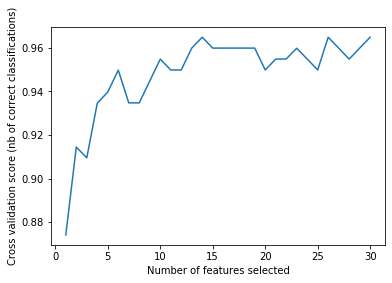

In [65]:
print("Optimal number of features : %d" % rfecv_rf.n_features_)
print("Optimal features: \n", breast_cancer.columns[rfecv_rf.get_support(indices=True)])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_rf.grid_scores_) + 1), rfecv_rf.grid_scores_)
plt.show()

In [66]:
X_train_dropped_rf = X_train[:,rfecv_rf.get_support(indices=True)]
X_test_dropped_rf = X_test[:,rfecv_rf.get_support(indices=True)]
rfecv_rf.fit(X_train_dropped_rf, y_train)
y_pred_dropped_rf = rfecv_rf.predict(X_test_dropped_rf)

In [67]:
print(y_pred_dropped_rf.shape)
print(classification_report(y_test, y_pred_dropped_rf)) 

(86,)
              precision    recall  f1-score   support

           B       1.00      1.00      1.00        57
           M       1.00      1.00      1.00        29

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



## Creating a GradientBoostingClassifier
__Score history:__

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 1.00 | 1.00, 1.00, 1.00 | 1.00, 1.00, 1.00 |
| - | - | - | - |

In [68]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV

In [69]:
pipe_gbc = PipelineRFE([
    ('gbc', GradientBoostingClassifier())
])

In [70]:
params_gbc = {
    'gbc__learning_rate': [0.05, 0.1, 0.15, 0.3],
    'gbc__max_depth': [4, 5, 6, 7, 9],
    'gbc__max_features': ['log2'],
    'gbc__n_estimators': [100, 200]
}

In [71]:
grid_gbc = GridSearchCV(estimator=pipe_gbc,
    param_grid=params_gbc,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)


In [72]:
grid_gbc.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=PipelineRFE(memory=None,
                                   steps=[('gbc',
                                           GradientBoostingClassifier(ccp_alpha=0.0,
                                                                      criterion='friedman_mse',
                                                                      init=None,
                                                                      learning_rate=0.1,
                                                                      loss='deviance',
                                                                      max_depth=3,
                                                                      max_features=None,
                                                                      max_leaf_nodes=None,
                                                                      min_impurity_decrease=0.0,
                                                                    

In [73]:
grid_gbc.best_params_

{'gbc__learning_rate': 0.15,
 'gbc__max_depth': 4,
 'gbc__max_features': 'log2',
 'gbc__n_estimators': 100}

In [74]:
grid_gbc.score(X_test, y_test)

1.0

In [75]:
y_pred_gbc = grid_gbc.predict(X_test)

In [76]:
print(classification_report(y_test, y_pred_gbc)) 

              precision    recall  f1-score   support

           B       1.00      1.00      1.00        57
           M       1.00      1.00      1.00        29

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



In [77]:
print(confusion_matrix(y_test, y_pred_gbc))
cm = confusion_matrix(y_test, y_pred_gbc)

[[57  0]
 [ 0 29]]


init (4, 5, 1, 2)


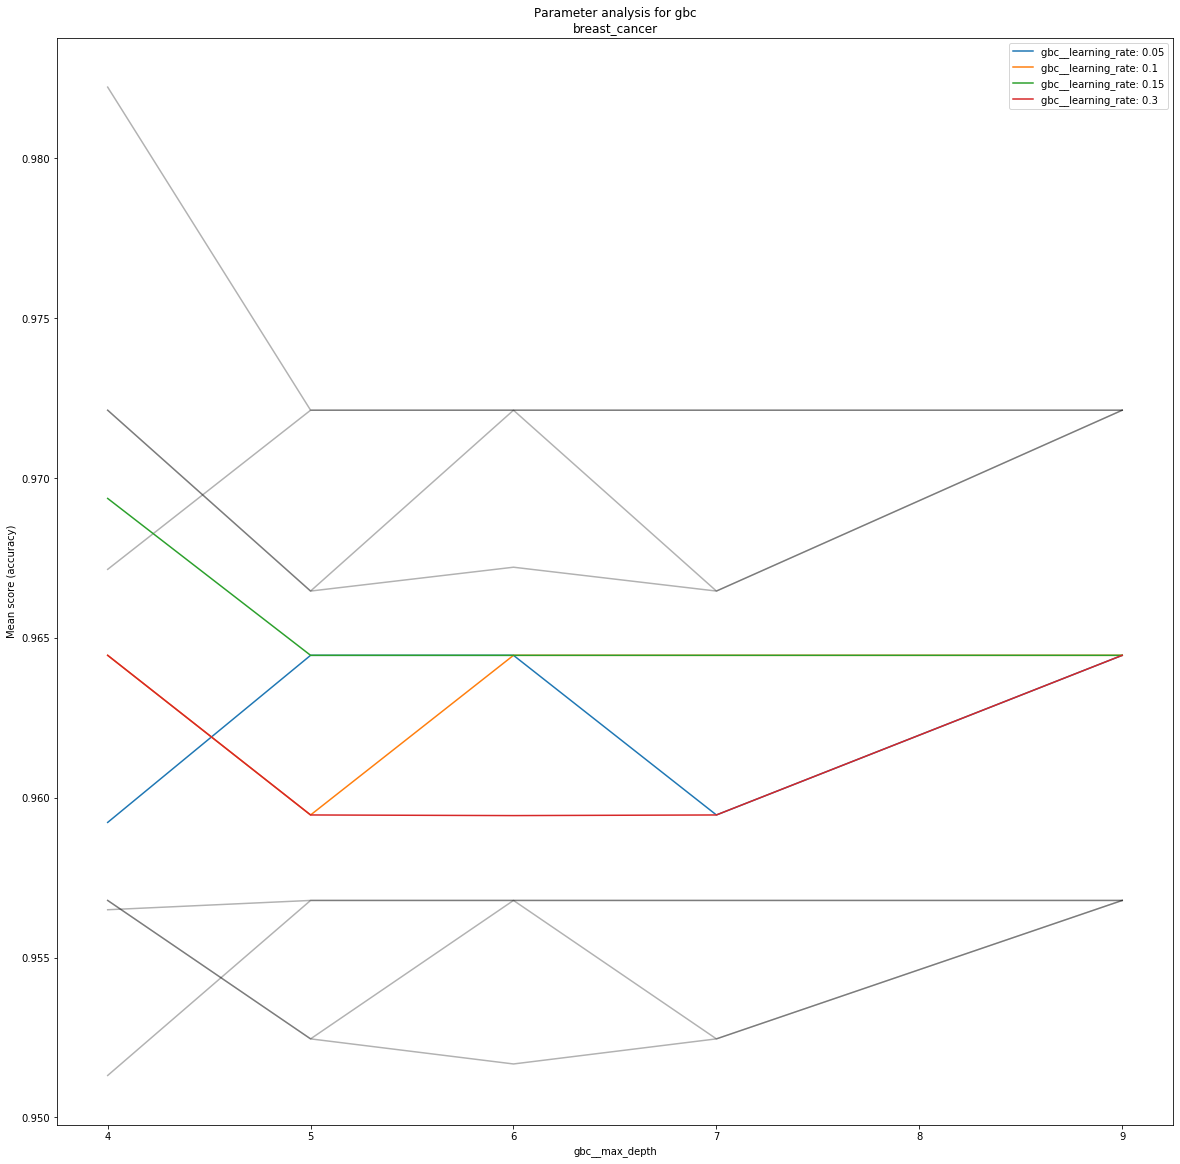

In [78]:
params_gbc_base = {
    'gbc__learning_rate': [0.05, 0.1, 0.15, 0.3],
    'gbc__max_depth': [4, 5, 6, 7, 9],
    'gbc__max_features': ['log2'],
    'gbc__n_estimators': [100]
}
plot_parameter_analysis(grid=grid_gbc, params=params_gbc, param1='gbc__max_depth',
                        param2='gbc__learning_rate', params_base=params_gbc_base,
                        method_name='gbc')

### train on full learn dataset and save output

In [187]:
grid_gbc.fit(X, y)
y_full_pred_gbc = grid_gbc.predict(X_full_test)
test_out_gbc = pd.DataFrame()
test_out_gbc['ID'] = breast_cancer_full_test['ID']
test_out_gbc['class'] = y_full_pred_gbc
test_out_gbc.to_csv('breast_cancer_test_gbc.csv', index=False)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   12.7s finished


In [188]:
grid_gbc.best_estimator_

Pipeline(memory=None,
         steps=[('gbc',
                 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=5, max_features='log2',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=200,
                                            n_iter_no_change=None,
                                            presort='auto', random_state=None,
                                            subsample=0.8, tol=0.0001,
                            

In [79]:
pipe_gbc.set_params(**grid_gbc.best_params_)
rfecv_gbc = RFECV(estimator=pipe_gbc, cv=3, scoring="accuracy")

In [80]:
rfecv_gbc.fit(X_train, y_train)

RFECV(cv=3,
      estimator=PipelineRFE(memory=None,
                            steps=[('gbc',
                                    GradientBoostingClassifier(ccp_alpha=0.0,
                                                               criterion='friedman_mse',
                                                               init=None,
                                                               learning_rate=0.15,
                                                               loss='deviance',
                                                               max_depth=4,
                                                               max_features='log2',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_lea

Optimal number of features : 9
Optimal features: 
 Index(['class', ' compactnessMean', ' textureStdErr', ' symmetryStdErr',
       ' fractalDimensionStdErr', ' radiusWorst', ' textureWorst',
       ' areaWorst', ' compactnessWorst'],
      dtype='object')


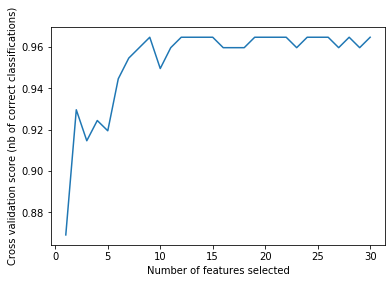

In [81]:
print("Optimal number of features : %d" % rfecv_gbc.n_features_)
print("Optimal features: \n", breast_cancer.columns[rfecv_gbc.get_support(indices=True)])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_gbc.grid_scores_) + 1), rfecv_gbc.grid_scores_)
plt.show()

In [82]:
X_train_dropped_gbc = X_train[:,rfecv_gbc.get_support(indices=True)]
X_test_dropped_gbc = X_test[:,rfecv_gbc.get_support(indices=True)]
rfecv_gbc.fit(X_train_dropped_gbc, y_train)
y_pred_dropped_gbc = rfecv_gbc.predict(X_test_dropped_gbc)

In [83]:
print(y_pred_dropped_gbc.shape)
print(classification_report(y_test, y_pred_dropped_gbc)) 

(86,)
              precision    recall  f1-score   support

           B       1.00      1.00      1.00        57
           M       1.00      1.00      1.00        29

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



## Creating MLP-Classifier



In [126]:
from sklearn.neural_network import MLPClassifier

In [173]:
mdl_mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.0001, 
						batch_size=400, learning_rate='constant', learning_rate_init=0.001, 
                        max_iter=300, tol=1e-6, verbose=True)


In [174]:
mdl_mlp.fit(X_train, y_train)

c:\users\redbull129\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:350: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
c:\users\redbull129\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = inf
Iteration 3, loss = inf
Iteration 4, loss = inf
Iteration 5, loss = inf
Iteration 6, loss = inf
Iteration 7, loss = inf
Iteration 8, loss = inf
Iteration 9, loss = inf
Iteration 10, loss = inf
Iteration 11, loss = inf
Iteration 12, loss = inf
Iteration 13, loss = inf
Iteration 14, loss = inf
Iteration 15, loss = inf
Iteration 16, loss = inf
Iteration 17, loss = inf
Iteration 18, loss = inf
Iteration 19, loss = inf
Iteration 20, loss = inf
Iteration 21, loss = inf
Iteration 22, loss = inf
Iteration 23, loss = inf
Iteration 24, loss = inf
Iteration 25, loss = inf
Iteration 26, loss = inf
Iteration 27, loss = inf
Iteration 28, loss = inf
Iteration 29, loss = inf
Iteration 30, loss = inf
Iteration 31, loss = inf
Iteration 32, loss = inf
Iteration 33, loss = inf
Iteration 34, loss = inf
Iteration 35, loss = inf
Iteration 36, loss = inf
Iteration 37, loss = inf
Iteration 38, loss = inf
Iteration 39, loss = inf
Iteration 40, loss = inf
Iteration

MLPClassifier(activation='relu', alpha=0.0001, batch_size=400, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=300, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=1e-06,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [175]:
mdl_mlp.score(X_test, y_test)

0.6627906976744186

In [176]:
y_pred_mdl = mdl_mlp.predict(X_test)

In [177]:
print(classification_report(y_test, y_pred_mdl)) 

              precision    recall  f1-score   support

           B       0.66      1.00      0.80        57
           M       0.00      0.00      0.00        29

    accuracy                           0.66        86
   macro avg       0.33      0.50      0.40        86
weighted avg       0.44      0.66      0.53        86



c:\users\redbull129\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [168]:
print(confusion_matrix(y_test, y_pred_mdl))
cm = confusion_matrix(y_test, y_pred_mdl)



[[ 0 57]
 [ 0 29]]
